# DENSER
My implementation of DENSER, a method for architecture selection in neural networks. The paper can be found [here](https://arxiv.org/abs/2004.11002).


## TO DO:
- [ ] Implement crossover in GA class
- [ ] Implement crossover in DSGE class
- [ ] Implement mutation in GA class
- [ ] Implement genetic algorithm

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scripts import utils, train
from scripts.dataloader import cifar10, MINST
import copy

%load_ext autoreload
%autoreload 2

/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Build the encoder from the DENSER paper 

Fristly we define the lower lavel of the grammatic: a DSGE gene. This class encode a single layer from all the possible one (conv, pool, activation). 
In addition, the class compute the input channels and the output channels of the layer, which depends on the kernel size and the padding.

In [2]:
class layer_type(Enum):
    "Layer types for DSGE."
    POOLING = 1
    CONV = 2
    ACTIVATION = 3
    LINEAR = 4

class pool(Enum):
    "Pooling types for DSGE."
    MAX = 1
    AVG = 2

class activation(Enum):
    "Activation types for DSGE."
    RELU = 1
    SIGMOID = 2
    TANH = 3
    SOFTMAX = 4

class Layer:
    "Layer class. "
    def __init__(self, type=None, c_in = None, c_out = None, param=None):
        if type is None: # Random init, no type specified (could be pooling, conv, activation, linear)
            self.random_init()
        else:
            self.init_form_encoding(type, param)
        self.channels = {'in': c_in, 'out': c_out}
        
        
    def random_init(self):
        self.type = layer_type(np.random.randint(1, 5))  #randomly choose a type
        self.random_init_param()                  #randomly choose the parameters of the type

    def random_init_param(self):
        if self.type == layer_type.POOLING:           #randomly choose a pooling type
            self.param = {"pool_type" : pool(np.random.randint(1, 3)), "kernel_size": np.random.randint(2, 5), "stride": np.random.randint(1, 3), "padding": np.random.randint(0, 2)}
        elif self.type == layer_type.CONV:         #randomly choose a kernel size, stride and padding
            self.param = {'kernel_size': np.random.randint(1, 3), 'stride': np.random.randint(1, 2), 'padding': np.random.randint(1, 2)}
        elif self.type == layer_type.ACTIVATION:   #randomly choose an activation type
            self.param = activation(np.random.randint(1, 4))
        elif self.type == layer_type.LINEAR:     #linear layer has no parameters
            self.param = None
    
    def init_form_encoding(self, type, param=None):
        self.type = type   #set the type
        if param is None:   #if no parameters are specified, randomly choose them
            self.random_init_param()
        
    def compute_shape(self, input_shape):
        if self.type == layer_type.CONV or self.type == layer_type.POOLING:
            return utils.compute_output_conv2d(input_shape, kernel_size=self.param['kernel_size'], stride=self.param['stride'], padding=self.param['padding'])
        else:
            return input_shape
    def fix_channels(self, c_in=None, c_out=None):
        if c_in is not None:
            self.channels['in'] = c_in
            if self.type != layer_type.CONV and self.type != layer_type.LINEAR:
                self.channels['out'] = c_in
        if c_out is not None:
            self.channels['out'] = c_out
            if self.type != layer_type.CONV and self.type != layer_type.LINEAR:
                self.channels['in'] = c_out
    def get(self):  #return the gene
        return self.type, self.param, self.channels

            
        
        




Then we are ready to encode the outer levels, the GA types, which describe a single block of the network (a sequence of DSGE genes). A block could be a features block (conv, pool, activation) or a classifier block (linear, activation). The GA types are encoded in the class M_type.

In [3]:
class module_types(Enum):
    "Layer types for GA."
    FEATURES = 1
    CLASSIFICATION = 2
    LAST_LAYER = 3

class Module:
    "GA_encoding class. The GA_encoding is composed of a list of genes."
    def __init__(self, M_type, c_in = None, c_out = None):
        self.M_type = M_type #set the type
        self.layers = []
        self.param  = {"input_channels": c_in, 'output_channels': c_out}
        

        if self.M_type == module_types.CLASSIFICATION :
            self.layers.append(Layer(layer_type.LINEAR, c_in = c_in, c_out = c_out    ))
            self.layers.append(Layer(layer_type.ACTIVATION, c_in = c_out, c_out = c_out  ))
            
        if self.M_type == module_types.LAST_LAYER :
            self.layers.append(Layer(layer_type.LINEAR, c_in = c_in, c_out = c_out    ))

        if self.M_type == module_types.FEATURES:
            self.layers.append(Layer(layer_type.CONV, c_in = c_in, c_out = c_out  ))
            self.layers.append(Layer(layer_type.ACTIVATION, c_in = c_out, c_out = c_out ) )
            self.layers.append(Layer(layer_type.POOLING, c_in = c_out, c_out = c_out  ))

    def len(self):
        return len(self.layers)  
           

    def compute_shape(self, input_shape):
        output_shape = input_shape
        for i in range(self.len()):
            output_shape = self.layers[i].compute_shape(output_shape)
        return output_shape

    def fix_channels(self,c_in=None, c_out=None):
        "fix the channels of the layers"
        if (c_out is not None):
            for i in range(self.len()):
                self.layers[i].fix_channels(c_out=c_out)

            self.param['output_channels'] = c_out
        elif(c_in is not None):
            self.layers[0].fix_channels(c_in=c_in)
            self.param['input_channels'] = c_in

    def get(self):
        return self.M_type, self.layers, self.param

    def print(self): #print the GA_encoding
        print( self.M_type)
        for i in range(len(self.layers)):
            print( self.layers[i].get())
        print("param: ", self.param)
            

Finally, we encode the whole network, the GA, which is a sequence of GA types:

In [4]:
class Net_encoding:
    "Describe the encoding of a network."
    def __init__(self, len_features, len_classification, c_in , c_out, input_shape):
  
        self.features = []
        self.classification = []
        self.last_layer = []
        self.input_shape = input_shape
        channels = self.init_random_channel(c_in, c_out, len_features + len_classification + 1 )
        


        for i in range(len_features):
            self.features.append(   Module(module_types.FEATURES, c_in = channels[i][0], c_out = channels[i][1]   )    )
            
        k = len_features
        channels[k] = ( (self.compute_shape_features(self.input_shape) ** 2) * channels[k-1][1], channels[k][1])   #set the input channels of the classification block: the flatten output of the features block
        for i in range(len_classification ):
            self.classification.append(   Module(     module_types.CLASSIFICATION,  c_in = channels[k+i][0], c_out = channels[k+i][1]  )  )

        self.last_layer.append(Module( module_types.LAST_LAYER,  c_in = channels[self.len_classification() + k][0], c_out = c_out)  )
        
 
        self.param = {'input_channels': c_in ,'output_channels': c_out}
        
    def _len(self):
        x =  len(self.features) +  len(self.classification) + 1
        return  x #the length of the encoding is the number of features block and classification block
    def len_features(self):
        x = len(self.features)
        return x
    def len_classification(self):
        x = len(self.classification) 
        return x  

    def GA_encoding(self, i):
        "Give the module at position i"
        if i < self.len_features():
            return self.features[i]
        elif i < self.len_features() + self.len_classification():
            return self.classification[i - self.len_features() ]
        elif i == self.len_features() + self.len_classification():
            return self.last_layer[0]
        else:
            return self.last_layer[0]

    def init_random_channel(self, C_in, C_out, len):
        tmp = C_in
        channels = []
        for i in range(len-1):
            out  = np.random.randint(7,30)
            channels.append( (tmp, out ) )
            tmp = out

        channels.append((tmp, C_out))
        return channels
    
    def compute_shape_features(self, input_shape = 32):
        "like the forward pass, compute the output shape of the features block"
        output_shape = input_shape
        for i in range(self.len_features()):
            output_shape = self.features[i].compute_shape(output_shape)
        return output_shape

    def get(self):
        return self.GA_encoding
        
    def print(self):
        print("Net encoding len:", self._len())
        for i in range(self._len()):
            print( self.GA_encoding(i).print())

    def print_GAlevel(self):
        "print only if the module is FEATURES or CLASSIFICATION"
        print("Net len:", self._len())
        for i in range(self._len()):
            print("-",i, self.GA_encoding(i).M_type)


    def fix_channels(self, cut1, cut2):
        "Given a new list of modules between cut1 and cut2, fix the channels of the modules"
        if cut1 != 0:
            c_out = self.GA_encoding(cut1-1).param['output_channels']
            c_in = self.GA_encoding(cut1).param['input_channels']
            new = min (c_in, c_out)
            self.GA_encoding(cut1-1).fix_channels(c_out = new)
            self.GA_encoding(cut1).fix_channels(c_in = new)

            c_out = self.GA_encoding(cut2-1).param['output_channels']
            c_in = self.GA_encoding(cut2).param['input_channels']
            new = min (c_in, c_out)
            self.GA_encoding(cut2-1).fix_channels(c_out = new)
            self.GA_encoding(cut2).fix_channels(c_in = new)
        last_in = (self.compute_shape_features(self.input_shape) ** 2) * self.features[-1].param['output_channels']
        self.classification[0].fix_channels(c_in = last_in)
        



        
def GA_crossover(parent1, parent2):
        "cut the parent1 and parent2 at random position and swap the two parts"
        #find cutting point
        cut_parent1 = np.random.randint(0, parent1._len() -1)
        cut_parent2 = np.random.randint(0, parent2._len() -1)
        
        #identify the type of the cut
        cut1_type = parent1.GA_encoding(cut_parent1).M_type
        cut2_type = parent2.GA_encoding(cut_parent2).M_type

        if cut1_type == module_types.FEATURES and cut2_type == module_types.CLASSIFICATION or cut_parent1==0 or cut_parent2==0:
            
            return parent1, parent2

        if cut1_type == cut2_type and cut1_type == module_types.FEATURES:
            print("FEATURES")
            aux1 = copy.deepcopy(parent1.features[cut_parent1:])
            aux2 = copy.deepcopy(parent2.features[cut_parent2:])
   
            parent1.features = copy.deepcopy(parent1.features[:cut_parent1])
            parent2.features = copy.deepcopy(parent2.features[:cut_parent2])
            
            parent1.features.extend(aux2)
            parent2.features.extend(aux1)
            parent1.fix_channels(cut_parent1, parent1.len_features())
            parent2.fix_channels(cut_parent2, parent2.len_features())

            return parent1, parent2
        if cut1_type == cut2_type and cut1_type == module_types.CLASSIFICATION:
            print("CLASSIFICATION")
            aux1 = copy.deepcopy(parent1.classification[cut_parent1 - parent1.len_features():])
            aux2 = copy.deepcopy(parent2.classification[cut_parent2 - parent2.len_features():])
   
            parent1.classification = copy.deepcopy(parent1.classification[:cut_parent1 - parent1.len_features()])
            parent2.classification = copy.deepcopy(parent2.classification[:cut_parent2 - parent2.len_features()])
            
            parent1.classification.extend(aux2)
            parent2.classification.extend(aux1)
            parent1.fix_channels(cut_parent1, parent1.len_features() + parent1.len_classification())
            parent2.fix_channels(cut_parent2, parent2.len_features() + parent2.len_classification())
            return parent1, parent2

        return parent1 , parent2


In [5]:
parent1 = Net_encoding(4, 1, 1, 10, 28)
parent2 = Net_encoding(3, 1, 1, 10, 28)
parent1.print_GAlevel()
parent2.print_GAlevel()
child1, child2 = GA_crossover(parent1, parent2)


Net len: 6
- 0 module_types.FEATURES
- 1 module_types.FEATURES
- 2 module_types.FEATURES
- 3 module_types.FEATURES
- 4 module_types.CLASSIFICATION
- 5 module_types.LAST_LAYER
Net len: 5
- 0 module_types.FEATURES
- 1 module_types.FEATURES
- 2 module_types.FEATURES
- 3 module_types.CLASSIFICATION
- 4 module_types.LAST_LAYER


Let's try to build a network with 4 features blocks and 2 classifier blocks, with a 3 channel input (a standard RGB image) and a 10 channel output (class of CIFAR-10):

## From the encoding to the neural network
Now we can build the neural network module from the encoding. We have only to select the correct layer from the DSGE gene and to connect them in the correct order. All the information are contained in the Net_encoding class.

In [32]:
class Net(nn.Module):
    def __init__(self, Net_encod):
        super().__init__()
        
        self.layer_list = []
        
        for i in range(Net_encod.len_features()):
            for j in range(Net_encod.GA_encoding(i).len()):
                layer = self.make_layer(Net_encod.GA_encoding(i).layers[j])
                self.layer_list.append(layer)

        self.layer_list.append(nn.Flatten() )

        for i in range(Net_encod.len_classification()):
            for j in range(Net_encod.GA_encoding(Net_encod.len_features() + i).len()):
                self.layer_list.append( self.make_layer(Net_encod.GA_encoding(Net_encod.len_features() + i).layers[j]))
        self.layer_list.append(self.make_layer(Net_encod.last_layer[0].layers[0]) )
        self.layers = nn.Sequential(*self.layer_list)


    def make_layer(self, dsge_encod):
            if dsge_encod.type == layer_type.CONV:
                return nn.Conv2d(dsge_encod.channels['in'], dsge_encod.channels['out'], dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
            if dsge_encod.type == layer_type.LINEAR:
                    return nn.Linear(dsge_encod.channels['in'], dsge_encod.channels['out'])
            if dsge_encod.type == layer_type.ACTIVATION:
                if dsge_encod.param == activation.RELU:
                    return nn.ReLU()
                if dsge_encod.param == activation.SIGMOID:
                    return nn.Sigmoid()
                if dsge_encod.param == activation.TANH:
                    return nn.Tanh()
            if dsge_encod.type == layer_type.POOLING:
                if dsge_encod.param["pool_type"] == pool.MAX:
                    return nn.MaxPool2d(dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
                if dsge_encod.param["pool_type"] == pool.AVG:
                    return nn.AvgPool2d(dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
    def forward(self, x):
        for i in range(len(self.layer_list)):
            # print("in", i,self.layer_list[i], x.shape)
            x = self.layer_list[i](x)
            # print("out", x.shape)
        return x
 


Let's try the network on MINST:

In [25]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# We download the train and the test dataset in the given root and applying the given transforms
trainset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,  download=True, transform=transform)

batch_size=4

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 1, 28, 28])


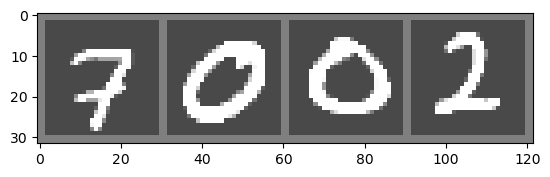

tensor([7, 0, 0, 2])
in 0 Conv2d(1, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)) torch.Size([4, 1, 28, 28])
out torch.Size([4, 20, 29, 29])
in 1 ReLU() torch.Size([4, 20, 29, 29])
out torch.Size([4, 20, 29, 29])
in 2 AvgPool2d(kernel_size=2, stride=1, padding=1) torch.Size([4, 20, 29, 29])
out torch.Size([4, 20, 30, 30])
in 3 Conv2d(20, 19, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)) torch.Size([4, 20, 30, 30])
out torch.Size([4, 19, 31, 31])
in 4 Tanh() torch.Size([4, 19, 31, 31])
out torch.Size([4, 19, 31, 31])
in 5 AvgPool2d(kernel_size=2, stride=2, padding=0) torch.Size([4, 19, 31, 31])
out torch.Size([4, 19, 15, 15])
in 6 Conv2d(19, 12, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)) torch.Size([4, 19, 15, 15])
out torch.Size([4, 12, 17, 17])
in 7 ReLU() torch.Size([4, 12, 17, 17])
out torch.Size([4, 12, 17, 17])
in 8 MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False) torch.Size([4, 12, 17, 17])
out torch.Size([4, 12, 9, 9])
in 9 Conv2d(

In [26]:
images , classes = next(iter(trainloader))
netcode = Net_encoding( 4, 2, 1, 10 , 28)
model = Net(netcode)
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print(images.shape)
imgshow(torchvision.utils.make_grid(images))
print(classes)
print(model(images))


In [9]:
netcode.print()

Net encoding len: 6
module_types.FEATURES
(<layer_type.CONV: 2>, {'kernel_size': 1, 'stride': 1, 'padding': 1}, {'in': 1, 'out': 17})
(<layer_type.ACTIVATION: 3>, <activation.TANH: 3>, {'in': 17, 'out': 17})
(<layer_type.POOLING: 1>, {'pool_type': <pool.AVG: 2>, 'kernel_size': 4, 'stride': 2, 'padding': 1}, {'in': 17, 'out': 17})
param:  {'input_channels': 1, 'output_channels': 17}
None
module_types.FEATURES
(<layer_type.CONV: 2>, {'kernel_size': 2, 'stride': 1, 'padding': 1}, {'in': 17, 'out': 8})
(<layer_type.ACTIVATION: 3>, <activation.RELU: 1>, {'in': 8, 'out': 8})
(<layer_type.POOLING: 1>, {'pool_type': <pool.AVG: 2>, 'kernel_size': 2, 'stride': 1, 'padding': 1}, {'in': 8, 'out': 8})
param:  {'input_channels': 17, 'output_channels': 8}
None
module_types.FEATURES
(<layer_type.CONV: 2>, {'kernel_size': 1, 'stride': 1, 'padding': 1}, {'in': 8, 'out': 24})
(<layer_type.ACTIVATION: 3>, <activation.SIGMOID: 2>, {'in': 24, 'out': 24})
(<layer_type.POOLING: 1>, {'pool_type': <pool.MAX: 1>

In [8]:
#test on cifar10 --- DO NOT RUN IF YOU WANT MINST
#   trainloader, testloader, classes = cifar10()
#  model = Net(Net_encoding(5, 2, 3, 10, 32))

Files already downloaded and verified
Files already downloaded and verified


Create a model with an architecture selected with the DENSER grammar:

In [33]:
model = Net(Net_encoding(5, 2, 1, 10, 28))
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 21, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(21, 25, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(25, 17, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
    (8): AvgPool2d(kernel_size=3, stride=1, padding=0)
    (9): Conv2d(17, 27, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(27, 25, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=18225, out_features=26, bias=True)
    (17): T

In [27]:
from scripts.train import train, eval

In [34]:
train(model, trainloader, device="cpu")
eval(model, testloader, device="cpu")

evaluating: 100%|██████████| 2500/2500 [00:06<00:00, 360.41it/s]

Accuracy of the network on the 10000 test images: 87 %


87

# Implement the genetic algorithm

In [44]:
class evolution():
    def __init__(self, population_size=10, holdout=1, mating=True):
        """
        initial function fun is a function to produce nets, used for the original population
        scoring_function must be a function which accepts a net as input and returns a float
        """
        self.population_size = population_size
        self.population = []
        for _ in range(population_size):
            num_feat = np.random.randint(1, 10)
            num_class = np.random.randint(1, 10)
            self.population.append(Net_encoding(num_feat,num_class,1,10,28))

        self.best_organism = self.population[-1]
        self.best_score = self.scoring_function(self.best_organism)

        self.holdout = max(1, int(holdout * population_size))

        self.mating = True
        

    def generation(self):
        scores = [self.scoring_function(x) for x in self.population]
        self.population = [self.population[x] for x in np.argsort(scores)[::-1]]

        # update best organism and respective accuracy
        self.best_organism = copy.deepcopy(self.population[0])
        self.best_score = sorted(scores)[-1]
        
        new_population = [self.best_organism] # Ensure best organism survives
        for i in range(self.population_size - 1):
            parent_1_idx = i % self.holdout
            if self.mating:
                parent_2_idx = min(self.population_size - 1, int(np.random.exponential(self.holdout)))
            else:
                parent_2_idx = parent_1_idx
            offspring, _ = GA_crossover(self.population[parent_1_idx], self.population[parent_2_idx]) # to build new generation functions mate and mutate are called as well
            new_population.append(offspring)
        
        self.population = new_population

    def get_best_organism(self, repeats=1):        
        return self.best_organism, self.best_score

    def training_function(self, netcode, trainloader):
        model = Net(netcode)
        train(model, trainloader, device="cuda")
        return model

    def scoring_function(self, modelcode):
        correct = 0
        total = 0
        model = self.training_function(modelcode, trainloader)
        accuracy = eval(model, testloader, device="cuda")
        return accuracy

In [81]:
# initialize the class which will handle evolution of the NNs
curr_env = evolution( population_size=5, holdout=0.6, mating=True)

# get current most suitable network (organism)
best_net, score = curr_env.get_best_organism()
acc = [score]
best_nets = [best_net]

evaluating: 100%|██████████| 2500/2500 [00:04<00:00, 532.22it/s]

Accuracy of the network on the 10000 test images: 11 %


In [82]:
generations = 5
for i in range(generations):
    curr_env.generation()
    this_generation_best, score = curr_env.get_best_organism()
    best_nets.append(this_generation_best)
    acc.append(score)
    #if i%5==0:
    print("Generation ", i , "'s best network accuracy: ", score, "%")

evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 634.07it/s]


Accuracy of the network on the 10000 test images: 10 %


evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 770.31it/s] 

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:02<00:00, 845.01it/s]

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:02<00:00, 1117.15it/s]

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:04<00:00, 570.89it/s]

Accuracy of the network on the 10000 test images: 10 %
FEATURES
Generation  0 's best network accuracy:  11 %



evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 692.41it/s]

Accuracy of the network on the 10000 test images: 10 %



evaluating: 100%|██████████| 2500/2500 [00:02<00:00, 1020.93it/s]

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:02<00:00, 989.06it/s] 

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 641.55it/s]


Accuracy of the network on the 10000 test images: 11 %


evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 700.39it/s]

Accuracy of the network on the 10000 test images: 11 %
CLASSIFICATION
CLASSIFICATION
Generation  1 's best network accuracy:  11 %



evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 695.48it/s]

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:03<00:00, 625.02it/s]

Accuracy of the network on the 10000 test images: 11 %



evaluating: 100%|██████████| 2500/2500 [00:02<00:00, 1035.05it/s]

Accuracy of the network on the 10000 test images: 10 %



training:   0%|          | 0/1250 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x26 and 26908x15)